In [11]:
# imports

import os
import warnings
import cv2
import easyocr
import imutils
import keras_ocr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import pytesseract
import nb_black
import fastwer
from PIL import Image, ImageEnhance
from sklearn.metrics import jaccard_score

pytesseract.pytesseract.tesseract_cmd = "C:/Program Files/Tesseract-OCR/tesseract.exe"
warnings.filterwarnings("ignore")
%load_ext lab_black


# Check output metrics
REAL_VALUES = {
    "Cars299.jpg": "SDN7484U",
    "Cars393.jpg": "M771276",
    "Cars418.jpg": "OX65AWD",
    "Cars73.jpg": "TN99F2378",
    "Cars14.jpg": "ALR486",
    "Cars104.jpg": "NL60LXB",
    "Cars105.jpg": "SBA1234A",
    "Cars123.jpg": "HR26BC5514",
    "Cars167.jpg": "15-LK-10898",
    "Cars17.jpg": "YSX213",
    "Cars197.jpg": "LR33TEE",
    "Cars198.jpg": "MH01AV8866",
    "Cars199.jpg": "MH01AE8017",
    "Cars287.jpg": "DL7CN5617",
    "Cars293.jpg": "GBI8TCE",
    "Cars301.jpg": "G526JHD",
    "Cars302.jpg": "JPK6546",
    "Cars305.jpg": "SGQ51JU",
    "Cars432.jpg": "DL49AK49",
    "Cars52.jpg": "MH15BD8877",
}
REAL_VALUES_DF = pd.DataFrame(
    list(REAL_VALUES.items()), columns=["Image", "real_plate"]
)


class PlateRecognition:
    def __init__(self):
        pass

    def __filters(self, img):
        """
        Preprocessing images for the OpenCV method.

        Args:
            img: image that will be preprocessed

        Return:
            preprocessed image with some new features -> gray, bilateralfilter and edged
        """
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        bfilter = cv2.bilateralFilter(gray, 11, 17, 17)  # Noise reduction
        edged = cv2.Canny(bfilter, 30, 200)  # Edge detection
        return gray, bfilter, edged

    def __search_plate_and_crop(self, img, edged, gray):
        """
        Use the preprocessed images to find countours and consequently crop the images

        Args:
            img: real image
            edged: edged image (_filters method)
            gray: gray image (_filters method)

        Return:
            image with the contours, his coordinates and the cropped.
        """
        keypoints = cv2.findContours(
            edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )
        contours = imutils.grab_contours(keypoints)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

        location = 0
        for contour in contours:
            approx = cv2.approxPolyDP(contour, 10, True)
            if len(approx) == 4:
                location = approx
                break
        mask = np.zeros(gray.shape, np.uint8)
        new_image = cv2.drawContours(mask, [location], 0, 255, -1)
        new_image = cv2.bitwise_and(img, img, mask=mask)

        (x, y) = np.where(mask == 255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))
        cropped_image = gray[x1 : x2 + 1, y1 : y2 + 1]
        return new_image, approx, cropped_image

    def __create_new_folder(self, path, folder_name):
        """
        Create a new folder based on the args.

        Args:
            path: path that will be created the new folder
            folder_name: the name of the folder that will be created in this path.

        Return:
            path of the new folder.
        """
        try:
            current_path = os.getcwd()
            os.chdir(".")
            path = os.getcwd()
            full_path = os.path.join(path, folder_name)
            os.makedirs(full_path)
            os.chdir(current_path)
            return full_path
        except OSError as error:
            print(f"-- Folder already created: {folder_name}")
            full_path = os.path.join(path, folder_name)
            return full_path

    def __plot_images(self, img1, img2, title1="", title2=""):
        fig = plt.figure(figsize=[15, 15])
        ax1 = fig.add_subplot(121)
        ax1.imshow(img1, cmap="gray")
        ax1.set(xticks=[], yticks=[], title=title1)

        ax2 = fig.add_subplot(122)
        ax2.imshow(img2, cmap="gray")
        ax2.set(xticks=[], yticks=[], title=title2)

        return fig

    def __resize_images(self, img_path):
        """
        Increase the image size if it is too small

        Args:
            img: real image

        Return:
            image with four times bigger.
        """
        min_size = 500

        img = Image.open(img_path)
        width, height = img.size
        if width < min_size or height < min_size:
            if width < height:
                new_width = min_size
                new_height = int(height * (min_size / width))
            else:
                new_height = min_size
                new_width = int(width * (min_size / height))
            img = img.resize((new_width, new_height), Image.BICUBIC)
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        return img

    def __preprocess_images(self, output_dir, directory):
        new_width = 115
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        for filename in os.listdir(directory):
            if filename.endswith(".jpg") or filename.endswith(
                ".png"
            ):  # altere de acordo com o formato das suas imagens
                img_path = os.path.join(directory, filename)
                img = Image.open(img_path)
                width, height = img.size
                if width < new_width:
                    new_height = int(height * new_width / width)
                    img = img.resize((new_width, new_height))

                # Aplica aumento de contraste na imagem
                enhancer = ImageEnhance.Contrast(img)
                enhanced_img = enhancer.enhance(
                    2.0
                )  # altere o fator de aumento de contraste conforme necessário

                # Salva a imagem com o mesmo nome e formato de antes, em um novo diretório
                output_path = os.path.join(output_dir, filename)
                enhanced_img.save(output_path)
        return output_dir

    def __preprocess_jaccard(self, df):
        """
        Function to preprocess a pandas DataFrame containing columns 'real_plate' and 'predicted_plate'.

        Args:
            DataFrame to be preprocessed.

        Return:
            Preprocessed DataFrame.
        """
        for index, row in df.iterrows():
            real_plate = row["real_plate"]
            predicted_plate = row["predicted_plate"]

            if len(predicted_plate) < len(real_plate):
                predicted_plate = predicted_plate.ljust(len(real_plate))
            elif len(real_plate) < len(predicted_plate):
                real_plate = real_plate.ljust(len(predicted_plate))

            df.at[index, "real_plate"] = real_plate
            df.at[index, "predicted_plate"] = predicted_plate

        return df

    def __jaccard_evaluation(self, real_df, predicted_df):
        """
        Function to use jaccard metric to evaluate OCR outputs (results)

        Args:
            real_df: manual labeled dataframe about the real dataset with Image.jpg and plate
            predicted_df: dataframe outputs from OCR methods

        Return:
            Jaccard value metric
        """
        df = real_df.merge(predicted_df)
        df.rename({"Plate": "predicted_plate"}, axis=1, inplace=True)
        df_aux = df
        df = self.__preprocess_jaccard(df)
        real_list = df["real_plate"].tolist()
        predicted_list = df["predicted_plate"].tolist()
        jaccard_metric = jaccard_score(real_list, predicted_list, average="weighted")
        print(f"Jaccard score: {jaccard_metric}")
        return df_aux

    def __ocr_metrics(self, real_df, predicted_df):
        df = real_df.merge(predicted_df)
        df.rename({"Plate": "predicted_plate"}, axis=1, inplace=True)
        df["predicted_plate"] = df["predicted_plate"].str.replace(
            " ", ""
        )  # remove blank spaces to improve metrics
        for index, row in df.iterrows():
            if pd.isnull(row["predicted_plate"]):
                row["predicted_plate"] = ""
            cer = fastwer.score_sent(
                row["predicted_plate"], row["real_plate"], char_level=True
            )
            wer = fastwer.score_sent(
                row["predicted_plate"], row["real_plate"], char_level=False
            )
            df.loc[df["Image"] == row["Image"], "CER"] = round(cer, 2)
            df.loc[df["Image"] == row["Image"], "WER"] = round(wer, 2)

        mean_cer = round(df["CER"].mean(), 2)
        mean_wer = round(df["WER"].mean(), 2)
        print(f"Mean CER = {mean_cer}%\nMean WER = {mean_wer}%")

        return df

    def OpenCVeasy(self, path, folder_name, save_fig=False, show_steps=False):
        """
        Use threshold, edge detection to find countours for car plate detection. EasyOCR for image to text recognition.

        Args:
            path: directory path which contains the images
            folder_name: directory path which will contain the results
            show_steps: method for when using manual detection, where it can show step-by-step
                        what is happening with the image to be transcribed (opcional)
            save_fig: save images with bounding boxes around detected license plates. (opcional)

        Return:
            DataFrame.csv with the labeled plate of each car (image)
        """
        self.path = path
        self.folder_name = folder_name
        df_lista = []

        full_path = self.__create_new_folder(path, folder_name)

        for dirpath, dirnames, filenames in os.walk(path):
            for filename in filenames:
                try:
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        img = cv2.imread(os.path.join(path, filename))
                        # img = self.__resize_images(img)
                        gray, bfilter, edged = self.__filters(img)
                        new_image, approx, cropped_image = self.__search_plate_and_crop(
                            img, edged, gray
                        )

                        reader = easyocr.Reader(["en"])
                        result = reader.readtext(cropped_image)

                        text = result[0][-2]
                        df_lista.append((filename, text.upper()))
                        font = cv2.FONT_HERSHEY_SIMPLEX
                        res = cv2.putText(
                            img,
                            text=text,
                            org=(approx[1][0][0], approx[2][0][1] + 30),
                            fontFace=font,
                            fontScale=0.7,
                            color=(0, 255, 0),
                            thickness=3,
                            lineType=cv2.LINE_AA,
                        )
                        res = cv2.rectangle(
                            img,
                            tuple(approx[0][0]),
                            tuple(approx[2][0]),
                            (0, 255, 0),
                            3,
                        )
                        # plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
                        if save_fig == True:
                            plt.savefig(os.path.join(full_path, filename))
                except IndexError as IE:
                    print(f"\n\nIndex Error in {filename}")
                    continue
                except Exception as error:
                    print(f"\n\nImage Error {filename}")
                    continue

        df_aux = pd.DataFrame(df_lista)
        df_aux.rename(columns={0: "Image", 1: "Plate"}, inplace=True)
        df = df_aux.sort_values("Image").to_csv(
            os.path.join(full_path, "opencv_results.csv"), index=False
        )

        if show_steps == True:
            self.__plot_images(img, gray, title1="original", title2="gray")
            self.__plot_images(gray, bfilter, title1="gray", title2="bfilter")
            self.__plot_images(bfilter, edged, title1="bfilter", title2="edged")
            self.__plot_images(
                img, cropped_image, title1="original", title2="cropped_image"
            )

        df = pd.read_csv(os.path.join(full_path, "opencv_results.csv"))
        df_final = self.__ocr_metrics(REAL_VALUES_DF, df)

        return df_final.to_csv(
            os.path.join(full_path, "opencv_results.csv"), index=False
        )

    def YOLOeasy(self, path, folder_name):
        """
        Use yolov5 to crop the image to exclusively the plate (yolov5_crop_images.ipynb). EasyOCR to transform the plate into text.

        Args:
            path: directory path which contains the images (cropped images)
            folder_name: directory path which will contain the results

        Return:
            DataFrame.csv with the labeled plate of each car (image)
        """
        self.path = path
        self.folder_name = folder_name
        df_lista_yolo = []

        full_path = self.__create_new_folder(path, folder_name)

        for dirpath, dirnames, filenames in os.walk(path):
            for filename in filenames:
                try:
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        output_dir = self.__preprocess_images(
                            "preprocessed_samples", dirpath
                        )
                    img = cv2.imread(os.path.join(output_dir, filename))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    reader = easyocr.Reader(["en"])
                    result = reader.readtext(img)
                    text = result[0][-2]
                    df_lista_yolo.append((filename, text.upper()))

                except IndexError as IE:
                    print(f"\n\nIndex Error in {filename}")
                    continue
                except Exception as error:
                    print(f"\n\nImage Error {filename}")
                    continue

        df_aux = pd.DataFrame(df_lista_yolo)
        df_aux.rename(columns={0: "Image", 1: "Plate"}, inplace=True)
        df = df_aux.sort_values("Image").to_csv(
            os.path.join(full_path, "easy_results.csv"), index=False
        )
        df = pd.read_csv(os.path.join(full_path, "easy_results.csv"))
        df_final = self.__ocr_metrics(REAL_VALUES_DF, df)

        return df_final.to_csv(os.path.join(full_path, "easy_results.csv"), index=False)

    def YOLOpytesseract(self, path, folder_name):
        """
        Use yolov5 to crop the image to exclusively the plate (yolov5_crop_images.ipynb). PytesseractOCR to transform the plate into text.

        Args:
            path: directory path which contains the images (cropped images)
            folder_name: directory path which will contain the results

        Return:
            DataFrame.csv with the labeled plate of each car (image)
        """
        full_path = self.__create_new_folder(path, folder_name)

        # Define the configuration for pytesseract
        custom_config = r"--oem 3 --psm 6 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

        df_lista_yolo = []
        for dirpath, dirnames, filenames in os.walk(path):
            for filename in filenames:
                try:
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        output_dir = self.__preprocess_images(
                            "preprocessed_samples", dirpath
                        )

                        img = cv2.imread(os.path.join(output_dir, filename))
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                        # Use pytesseract to extract text from the image
                        text = pytesseract.image_to_string(img, config=custom_config)
                        plate = re.sub(r"[^A-Za-z0-9]+", "", text)
                        df_lista_yolo.append((filename, plate.upper()))

                except cv2.error as e:
                    print(f"Error reading image file {filename}: {e}")
                except pytesseract.TesseractError as e:
                    print(f"Error processing image file {filename}: {e}")

        # Convert the list to a pandas DataFrame and save to a CSV file
        df = pd.DataFrame(df_lista_yolo, columns=["Image", "Plate"])
        df = df.sort_values("Image").to_csv(
            os.path.join(full_path, "pytesseract_results.csv"), index=False
        )
        df = pd.read_csv(os.path.join(full_path, "pytesseract_results.csv"))
        df_final = self.__ocr_metrics(REAL_VALUES_DF, df)

        return df_final.to_csv(
            os.path.join(full_path, "pytesseract_results.csv"), index=False
        )

    def YOLOkeras(self, path, folder_name, show_annotations=False):
        """
        Use yolov5 to crop the image to exclusively the plate (yolov5_crop_images.ipynb). KerasOCR to transform the plate into text.

        Args:
            path: directory path which contains the images
            folder_name: directory path which will contain the results

        Return:
            DataFrame.csv with the labeled plate of each car (image)
        """
        self.path = path
        self.folder_name = folder_name

        full_path = self.__create_new_folder(path, folder_name)

        pipeline_list = []
        df_keras = []
        for dirpath, dirnames, filenames in os.walk(path):
            for filename in filenames:
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    output_dir = self.__preprocess_images(
                        "preprocessed_samples", dirpath
                    )
                    pipeline_list = []
                    path_images = f"{output_dir}/" + filename
                    pipeline_list.append(path_images)

                    pipeline = keras_ocr.pipeline.Pipeline()
                    pipeline_images = [
                        keras_ocr.tools.read(img) for img in pipeline_list
                    ]
                    prediction_groups = pipeline.recognize(pipeline_images)

                    for content in prediction_groups:
                        print(f"\n --#-- Analysing {filename} --#--\n")
                        for text, box in content:
                            df_keras.append((filename, text.upper()))

        df_aux = pd.DataFrame(df_keras)
        df_aux.rename(columns={0: "Image", 1: "Plate"}, inplace=True)
        df = df_aux.sort_values("Image")
        df = (
            df.groupby("Image")
            .sum()
            .to_csv(os.path.join(full_path, "keras_results.csv"))
        )

        if show_annotations == True:
            for image, pred in zip(pipeline_images, prediction_groups):
                fig, ax = plt.subplots(1, 1, figsize=(10, 10))
                keras_ocr.tools.drawAnnotations(image=image, predictions=pred, ax=ax)

        df = pd.read_csv(os.path.join(full_path, "keras_results.csv"))
        df_final = self.__ocr_metrics(REAL_VALUES_DF, df)

        return df_final.to_csv(
            os.path.join(full_path, "keras_results.csv"), index=False
        )

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [6]:
PlateRecognition().YOLOpytesseract(path="cropped_samples/", folder_name="results")

-- Folder already created: results
Mean CER = 26.26%
Mean WER = 85.0%


In [9]:
PlateRecognition().YOLOkeras(path="cropped_samples/", folder_name="results")

-- Folder already created: results
Looking for C:\Users\caio_barros\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\caio_barros\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step

 --#-- Analysing Cars104.jpg --#--

Looking for C:\Users\caio_barros\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\caio_barros\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step

 --#-- Analysing Cars105.jpg --#--

Looking for C:\Users\caio_barros\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\caio_barros\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step

 --#-- Analysing Cars123.jpg --#--

Looking for C:\Users\caio_barros\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\caio_barros\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 1s 1s/step

 --#-- Analysing Cars14.jpg --#--

Looking for C:\Users\caio_barros\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\caio_barros\.keras-ocr\crnn_kurapan.h5
1/1 [========

In [8]:
PlateRecognition().YOLOeasy(path="cropped_samples/", folder_name="results")

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


-- Folder already created: results


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

Mean CER = 24.2%
Mean WER = 65.0%


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


-- Folder already created: results


Image Error Cars104.jpg


Image Error Cars105.jpg


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.




Index Error in Cars123.jpg


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.




Index Error in Cars167.jpg


Image Error Cars17.jpg


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.




Index Error in Cars198.jpg


Image Error Cars199.jpg


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.




Index Error in Cars293.jpg


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.




Index Error in Cars299.jpg


Image Error Cars301.jpg


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.




Image Error Cars305.jpg


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.




Index Error in Cars432.jpg


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Mean CER = 43.31%
Mean WER = 75.0%


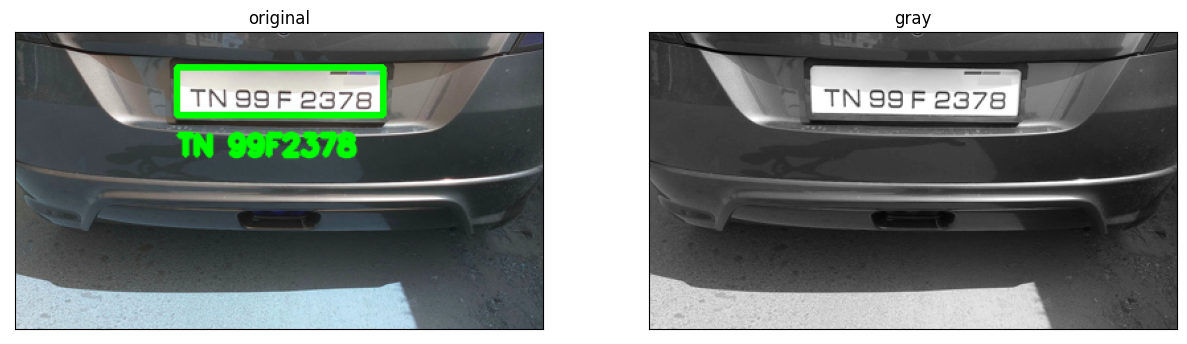

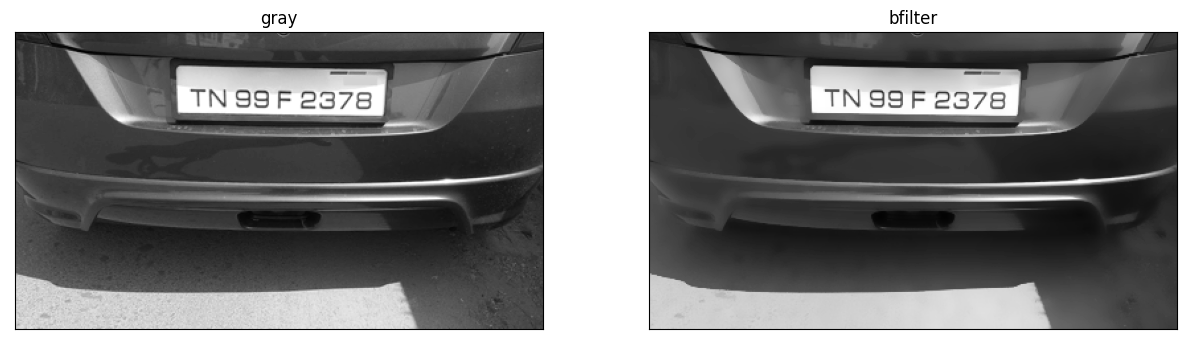

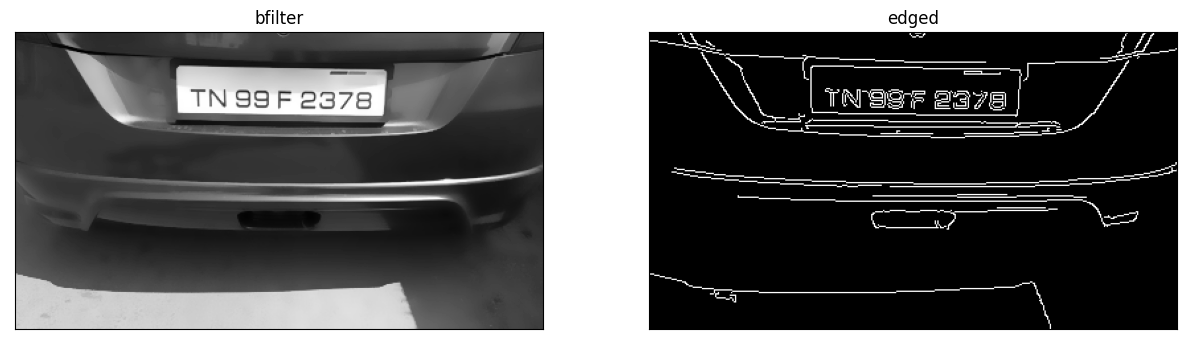

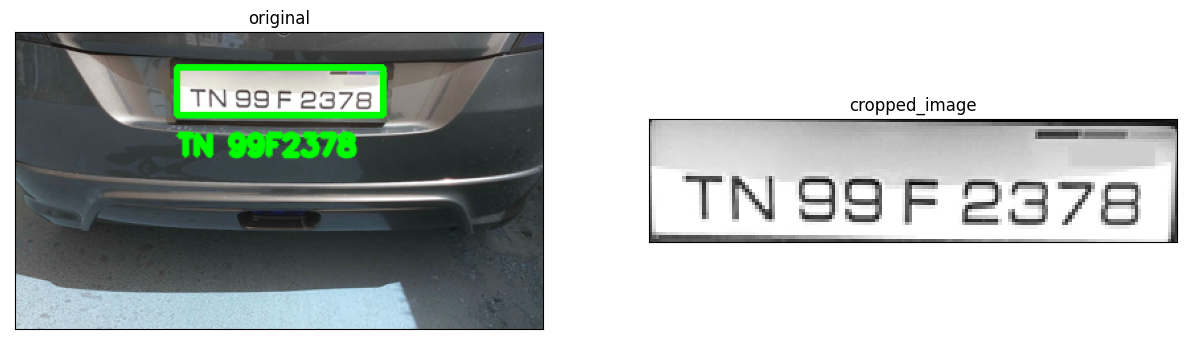

In [12]:
PlateRecognition().OpenCVeasy(
    path="original_samples/", folder_name="results", show_steps=True
)